# Imports

In [1]:
# Ajouter chemin système pour naviguer d'un dossier à l'autre facilement
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))

In [2]:
########## Installations ##########

#pip install plot-keras-history

# Setup particulier à faire sur Mac pour pouvoir faire data augmentation
# idéalement : faire un environnement virtuel (ici on essaiera de faire sans, mais à mettre en place sans faute pour le prochain projet)

# https://developer.apple.com/metal/tensorflow-plugin/
#!pip install tensorflow
#!pip install tensorflow-macos==2.9.0
#!pip install tensorflow-metal==0.5.1

In [6]:
########## Imports ##########
import pandas as pd
import numpy as np
import os
from glob import glob
import time
import pickle
from packages import fonctions

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
%matplotlib inline 
# vérifier si vraiment utile

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn import manifold, decomposition
from sklearn import cluster, metrics

# tensorflow
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import load_img, img_to_array
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers.legacy import Adam

#pip install plot-keras-history
from plot_keras_history import show_history, plot_history

os.environ['TF_KERAS'] = '1'
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
# Warnings
import warnings
warnings.simplefilter(action = 'ignore')

# Set display preferences
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 100)

In [8]:
# Choix d'une palette de couleurs

sns.set_palette('Set2', color_codes = True)
print(sns.color_palette('Set2').as_hex())
# palettes testées : 'Spectral', 'flare', 'twilight', 'husl', 'Set1', 'Set2', 'Set3'
#sns.set_style('darkgrid')
sns.color_palette()

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']


[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [9]:
########## Consignes ##########

# Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
# - un algorithme de type SIFT / ORB / SURF
# - un algorithme de type CNN Transfer Learning.
# Concernant l’approche de type SIFT, je t’invite à regarder le webinaire que nous avons réalisé, disponible dans les ressources

# Préparation des données

In [13]:
########## Import des données ##########

path = '' #-> en local
filepath = os.path.join(path, '../../data/data')

with open(filepath, 'rb') as f:
    data = pickle.load(f)

data.head()

,image_path,label_name,label
0,../../data/Images/aa68675f50a0551b8dadb954017a...,Home and Kitchen Essential,3
1,../../data/Images/037c2402fee39fbc80433935711d...,Baby and Personal Care,0
2,../../data/Images/42643c1c9403f67921a18654bcf4...,Baby and Personal Care,0
3,../../data/Images/53f4bc7d7321f5c41de6b86e41f1...,Home and Kitchen Essential,3
4,../../data/Images/b144a363c107c7bdd91f32d6e28b...,Home and Kitchen Essential,3


In [14]:
path = '' #-> en local
filepath = os.path.join(path, '../../data/df_image')

with open(filepath, 'rb') as f:
    df_image = pickle.load(f)

df_image.head()

,image_path,label_name,image_name,label
0,../../data/Images/aa68675f50a0551b8dadb954017a...,Home and Kitchen Essential,55b85ea15a1536d46b7190ad6fff8ce7.jpg,3
1,../../data/Images/037c2402fee39fbc80433935711d...,Baby and Personal Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,0
2,../../data/Images/42643c1c9403f67921a18654bcf4...,Baby and Personal Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,0
3,../../data/Images/53f4bc7d7321f5c41de6b86e41f1...,Home and Kitchen Essential,d4684dcdc759dd9cdf41504698d737d8.jpg,3
4,../../data/Images/b144a363c107c7bdd91f32d6e28b...,Home and Kitchen Essential,6325b6870c54cd47be6ebfbffa620ec7.jpg,3


# Etape 2 : classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


## Création du modèle de classification

In [59]:
# cf fichier fonctions.py

## Approche préparation initiale des images

In [60]:
# Séparer "data" en deux morceaux pour avoir data train et data test
data.shape

(1006, 3)

In [61]:
data

,image_path,label_name,label
0,../../data/Images/aa68675f50a0551b8dadb954017a...,Home and Kitchen Essential,3
1,../../data/Images/037c2402fee39fbc80433935711d...,Baby and Personal Care,0
2,../../data/Images/42643c1c9403f67921a18654bcf4...,Baby and Personal Care,0
3,../../data/Images/53f4bc7d7321f5c41de6b86e41f1...,Home and Kitchen Essential,3
4,../../data/Images/b144a363c107c7bdd91f32d6e28b...,Home and Kitchen Essential,3
...,...,...,...
1001,../../data/Images/4e5ebfc871992e7e22365c0c036a...,Baby and Personal Care,0
1002,../../data/Images/82fbc93cd45ab747e7e606f2c52c...,Baby and Personal Care,0
1003,../../data/Images/216c6c3527984be3d7ad9023d5cd...,Baby and Personal Care,0
1004,../../data/Images/f54d0c5cbd8e2270742293edf907...,Baby and Personal Care,0


In [62]:
# Séparation des données en train et en test
# XXXXX images
# on en prend environ 30% pour le jeu de données test
# 700 / 300 (donner les chiffres exacts)

In [63]:
data_train = data[:700]
data_train

,image_path,label_name,label
0,../../data/Images/aa68675f50a0551b8dadb954017a...,Home and Kitchen Essential,3
1,../../data/Images/037c2402fee39fbc80433935711d...,Baby and Personal Care,0
2,../../data/Images/42643c1c9403f67921a18654bcf4...,Baby and Personal Care,0
3,../../data/Images/53f4bc7d7321f5c41de6b86e41f1...,Home and Kitchen Essential,3
4,../../data/Images/b144a363c107c7bdd91f32d6e28b...,Home and Kitchen Essential,3
...,...,...,...
695,../../data/Images/534d9c3ae2342df2f4f9233622f9...,Festive and Special Occasion,2
696,../../data/Images/08613e8b27838b997069b1fedb6e...,Electronics and Accessories,1
697,../../data/Images/a63eecfbb02004863fa1f29a0b81...,Electronics and Accessories,1
698,../../data/Images/6ed34e1ab886e8a702ec59dd66ba...,Home and Kitchen Essential,3


In [64]:
data_test = data[700:]
data_test.reset_index(drop = True, inplace = True)

In [65]:
# dire ce qu'on fait ici
images_np = fonctions.image_prep_fct(data_train)
images_np

array([[[[ 95.061    ,  79.221    ,  68.32     ],
         [ 93.061    ,  76.221    ,  68.32     ],
         [ 95.061    ,  77.221    ,  71.32     ],
         ...,
         [ 71.061    ,  62.221    ,  56.32     ],
         [ 69.061    ,  60.221    ,  54.32     ],
         [ 66.061    ,  57.221    ,  51.32     ]],

        [[ 93.061    ,  77.221    ,  66.32     ],
         [ 93.061    ,  76.221    ,  68.32     ],
         [ 96.061    ,  78.221    ,  72.32     ],
         ...,
         [ 68.061    ,  59.221    ,  53.32     ],
         [ 68.061    ,  59.221    ,  53.32     ],
         [ 69.061    ,  60.221    ,  54.32     ]],

        [[ 94.061    ,  77.221    ,  69.32     ],
         [ 94.061    ,  77.221    ,  69.32     ],
         [ 95.061    ,  77.221    ,  71.32     ],
         ...,
         [ 70.061    ,  61.221    ,  55.32     ],
         [ 67.061    ,  58.221    ,  52.32     ],
         [ 64.061    ,  55.221    ,  49.32     ]],

        ...,

        [[ 84.061    ,  70.221    ,  6

In [66]:
images_np.shape

(700, 224, 224, 3)

In [67]:
images_np_test = fonctions.image_prep_fct(data_test)
images_np_test

array([[[[ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         ...,
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ]],

        [[ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         ...,
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ]],

        [[ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         ...,
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ]],

        ...,

        [[ 151.061   ,  138.22101 ,  1

In [68]:
images_np_test.shape

(306, 224, 224, 3)

In [69]:
X = images_np
X

array([[[[ 95.061    ,  79.221    ,  68.32     ],
         [ 93.061    ,  76.221    ,  68.32     ],
         [ 95.061    ,  77.221    ,  71.32     ],
         ...,
         [ 71.061    ,  62.221    ,  56.32     ],
         [ 69.061    ,  60.221    ,  54.32     ],
         [ 66.061    ,  57.221    ,  51.32     ]],

        [[ 93.061    ,  77.221    ,  66.32     ],
         [ 93.061    ,  76.221    ,  68.32     ],
         [ 96.061    ,  78.221    ,  72.32     ],
         ...,
         [ 68.061    ,  59.221    ,  53.32     ],
         [ 68.061    ,  59.221    ,  53.32     ],
         [ 69.061    ,  60.221    ,  54.32     ]],

        [[ 94.061    ,  77.221    ,  69.32     ],
         [ 94.061    ,  77.221    ,  69.32     ],
         [ 95.061    ,  77.221    ,  71.32     ],
         ...,
         [ 70.061    ,  61.221    ,  55.32     ],
         [ 67.061    ,  58.221    ,  52.32     ],
         [ 64.061    ,  55.221    ,  49.32     ]],

        ...,

        [[ 84.061    ,  70.221    ,  6

In [70]:
y = to_categorical(data['label'][:700])
y

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [71]:
X_test = images_np_test
X_test

array([[[[ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         ...,
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ]],

        [[ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         ...,
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ]],

        [[ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         ...,
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ]],

        ...,

        [[ 151.061   ,  138.22101 ,  1

In [72]:
data_test['label'].unique()

array([3, 0, 1, 2])

In [73]:
y_test = to_categorical(data_test['label'])
y_test

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [74]:
y_test.shape

(306, 4)

In [75]:
# Train test split (split en train et en validation) -> du coup on a un jeu de données train, un jeu de données validation et un jeu de données test
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, test_size = 0.25, random_state = 42)
X_train.shape

(525, 224, 224, 3)

In [76]:
X_test.shape

(306, 224, 224, 3)

In [77]:
y_train.shape

(525, 4)

In [78]:
# Création du modèle
with tf.device('/gpu:0'):
    model1 = fonctions.create_model_fct_1()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [79]:
# Création du callback
model1_save_path1 = './model1_best_weights.h5'
checkpoint = ModelCheckpoint(model1_save_path1, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
callbacks_list = [checkpoint, es]

In [80]:
# pourquoi 50 epoch
# pourquoi batch size de 64

In [81]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, epochs = 50, batch_size = 64, callbacks = callbacks_list, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/50


2024-03-09 13:04:36.963387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 8.1568 - accuracy: 0.2781

2024-03-09 13:04:49.111941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 4.85885, saving model to ./model1_best_weights.h5
9/9 [==============================] - 17s 2s/step - loss: 8.1568 - accuracy: 0.2781 - val_loss: 4.8589 - val_accuracy: 0.2343
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 4.9024 - accuracy: 0.3581
Epoch 2: val_loss improved from 4.85885 to 4.20853, saving model to ./model1_best_weights.h5
9/9 [==============================] - 15s 2s/step - loss: 4.9024 - accuracy: 0.3581 - val_loss: 4.2085 - val_accuracy: 0.2171
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 3.5212 - accuracy: 0.4152
Epoch 3: val_loss improved from 4.20853 to 3.49218, saving model to ./model1_best_weights.h5
9/9 [==============================] - 16s 2s/step - loss: 3.5212 - accuracy: 0.4152 - val_loss: 3.4922 - val_accuracy: 0.2343
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 2.8654 - accuracy: 0.4419
Epoch 4: val_loss improved from 3.49218 to 3.41518, saving model to

In [82]:
# choix de l'accuracy -> dire pourquoi

In [83]:
# Score du dernier epoch
loss, accuracy = model1.evaluate(X_train, y_train, verbose = True)
print('Training Accuracy: {:.4f}'.format(accuracy))

loss, accuracy = model1.evaluate(X_val, y_val, verbose = True)
print('Validation Accuracy: {:.4f}'.format(accuracy))

17/17 [==============================] - 9s 537ms/step - loss: 0.1189 - accuracy: 0.9905
Training Accuracy: 0.9905
6/6 [==============================] - 3s 501ms/step - loss: 2.8689 - accuracy: 0.2686
Validation Accuracy: 0.2686


In [84]:
# Score de l'epoch optimal
model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose = False)
print('Validation Accuracy : {:.4f}'.format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose = False)
print('Test Accuracy : {:.4f}'.format(accuracy))

Validation Accuracy : 0.2286
Test Accuracy : 0.2451


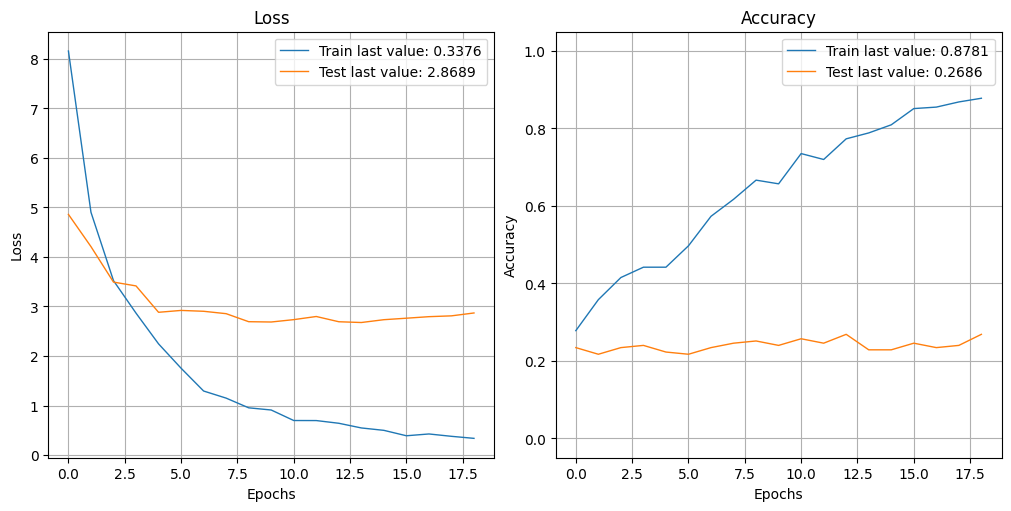

In [85]:
# plot blablabla

show_history(history1)
plot_history(history1, path = 'standard.png')
plt.close()

In [86]:
y_val_num = np.argmax(y_val, axis = 1)
print(y_val_num)

[0 1 3 0 2 1 0 2 0 2 1 1 0 3 1 1 0 0 2 1 3 1 1 3 2 1 0 0 0 0 0 0 1 1 0 1 1
 1 3 2 1 0 0 1 0 0 1 0 3 3 3 3 1 1 1 1 0 1 2 1 0 3 3 0 3 2 0 1 1 2 3 3 3 1
 3 2 3 0 1 2 0 1 1 3 2 2 3 3 1 3 0 3 0 0 1 3 3 2 2 0 3 0 2 0 3 0 0 1 3 3 0
 1 3 1 2 0 1 3 1 0 3 1 2 3 1 2 1 0 0 1 1 3 0 1 1 2 0 2 1 2 2 2 0 1 0 0 0 1
 1 1 3 0 0 1 2 3 0 0 2 1 1 1 1 3 3 3 0 3 2 3 0 3 2 1 0]


In [87]:
y_val_pred = np.argmax(model1.predict(X_val), axis = 1)
print(y_val_pred)

2024-03-09 13:09:28.974570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 4s 533ms/step
[1 1 1 1 2 3 3 1 1 0 0 3 1 0 1 0 1 0 0 3 0 2 2 2 1 3 1 0 0 1 0 1 1 1 0 0 3
 1 0 1 1 2 2 0 3 1 2 0 1 1 1 1 3 1 2 0 1 1 0 0 2 1 1 1 1 0 1 2 0 0 0 0 2 1
 1 0 0 3 3 1 0 3 0 1 3 2 2 1 3 1 1 0 3 0 1 1 3 1 2 1 3 0 3 1 1 2 1 0 2 1 3
 1 1 1 1 0 1 0 0 1 0 3 1 3 0 1 1 0 0 3 1 1 0 3 1 1 1 3 1 1 0 1 3 1 0 1 1 0
 3 0 1 1 1 0 3 1 1 1 0 2 0 1 0 0 3 2 2 0 0 1 1 0 3 2 1]


In [88]:
# Matrice de confusion

conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[14 26  5  6]
 [16 19  7 13]
 [ 9 11  3  5]
 [12 20  5  4]]


In [89]:
y_val_pred_transform = fonctions.conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)

Correspondance des clusters :  [1 0 1 1]
[[26 25  0  0]
 [19 36  0  0]
 [11 17  0  0]
 [20 21  0  0]]


In [90]:
# Rapport de classification :

print(metrics.classification_report(y_val_num, y_val_pred_transform))

              precision    recall  f1-score   support

           0       0.34      0.51      0.41        51
           1       0.36      0.65      0.47        55
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00        41

    accuracy                           0.35       175
   macro avg       0.18      0.29      0.22       175
weighted avg       0.21      0.35      0.27       175



In [91]:
# Mise sous forme de dataframe de la matrice de confusion ?
list_labels = data['label_name'].unique().tolist()
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels], columns = [i for i in '0123'])
df_cm

,0,1,2,3
Home and Kitchen Essential,26,25,0,0
Baby and Personal Care,19,36,0,0
Electronics and Accessories,11,17,0,0
Festive and Special Occasion,20,21,0,0


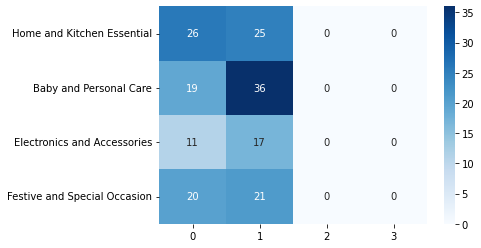

In [92]:
# Heatmap blabla

plt.figure(figsize = (6, 4))
sns.heatmap(df_cm, annot = True, cmap = 'Blues')
plt.show()

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [93]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac = 1, random_state = 42).reset_index(drop = True)

In [94]:
data['label_name'].unique()

array(['Baby and Personal Care', 'Home and Kitchen Essential',
       'Electronics and Accessories', 'Festive and Special Occasion'],
      dtype=object)

In [95]:
data

,image_path,label_name,label
0,../../data/Images/7f6678a6217c831b716feca796f6...,Baby and Personal Care,0
1,../../data/Images/3dfd14b667357e26ff6d66761cdc...,Baby and Personal Care,0
2,../../data/Images/d68b774e9529a4b94a5c6c8943a1...,Home and Kitchen Essential,3
3,../../data/Images/4cc971d2c9c0f1056bc124031ed5...,Electronics and Accessories,1
4,../../data/Images/63f2d92a3f5fc6cfc11e7f99d579...,Baby and Personal Care,0
...,...,...,...
1001,../../data/Images/d7fded8e211b3033e424fb450b97...,Home and Kitchen Essential,3
1002,../../data/Images/cd71b07a1d37a5e2cc04240e8498...,Home and Kitchen Essential,3
1003,../../data/Images/60395c709b4a933319e2713e3ae6...,Baby and Personal Care,0
1004,../../data/Images/b5834f1e97c74d2833dbcb09a3f2...,Baby and Personal Care,0


In [96]:
data = data[data['label_name'].notnull()]

In [97]:
data['label_name'] = data['label_name'].apply(lambda x : x.split(','))

In [98]:
batch_size = 32

In [99]:
data

,image_path,label_name,label
0,../../data/Images/7f6678a6217c831b716feca796f6...,[Baby and Personal Care],0
1,../../data/Images/3dfd14b667357e26ff6d66761cdc...,[Baby and Personal Care],0
2,../../data/Images/d68b774e9529a4b94a5c6c8943a1...,[Home and Kitchen Essential],3
3,../../data/Images/4cc971d2c9c0f1056bc124031ed5...,[Electronics and Accessories],1
4,../../data/Images/63f2d92a3f5fc6cfc11e7f99d579...,[Baby and Personal Care],0
...,...,...,...
1001,../../data/Images/d7fded8e211b3033e424fb450b97...,[Home and Kitchen Essential],3
1002,../../data/Images/cd71b07a1d37a5e2cc04240e8498...,[Home and Kitchen Essential],3
1003,../../data/Images/60395c709b4a933319e2713e3ae6...,[Baby and Personal Care],0
1004,../../data/Images/b5834f1e97c74d2833dbcb09a3f2...,[Baby and Personal Care],0


In [100]:
# ????? expliquer ce que je fais ici

datagen_train = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.25,
    preprocessing_function = preprocess_input
    )

train_flow = fonctions.data_flow_fct(batch_size, data, datagen_train, data_type = 'training')
val_flow = fonctions.data_flow_fct(batch_size, data, datagen_train, data_type = 'validation')

datagen_test = ImageDataGenerator(
    validation_split = 0,
    preprocessing_function = preprocess_input)

#test_flow = data_flow_fct(data_test, datagen_test, data_type = None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 755 validated image filenames belonging to 4 classes.
Found 251 validated image filenames belonging to 4 classes.


In [101]:
test_flow = fonctions.data_flow_fct(batch_size, data_test, datagen_test, data_type = None)
test_flow

Found 306 validated image filenames belonging to 4 classes.


In [102]:
data_test

,image_path,label_name,label
0,../../data/Images/0e73201f6d8807776e1d21c96907...,Home and Kitchen Essential,3
1,../../data/Images/db6c79a1d852944a89e157793f39...,Home and Kitchen Essential,3
2,../../data/Images/750f964cf8e6a16412aaf2b0d035...,Home and Kitchen Essential,3
3,../../data/Images/a8ea6fc2b3cd95f46bced80853ce...,Baby and Personal Care,0
4,../../data/Images/d376da2235096f74600d842b6f5f...,Baby and Personal Care,0
...,...,...,...
301,../../data/Images/4e5ebfc871992e7e22365c0c036a...,Baby and Personal Care,0
302,../../data/Images/82fbc93cd45ab747e7e606f2c52c...,Baby and Personal Care,0
303,../../data/Images/216c6c3527984be3d7ad9023d5cd...,Baby and Personal Care,0
304,../../data/Images/f54d0c5cbd8e2270742293edf907...,Baby and Personal Care,0


In [103]:
data_test = data_test[data_test['label_name'].notnull()]
data_test['label_name'] = data_test['label_name'].apply(lambda x : x.split(','))
data_test

,image_path,label_name,label
0,../../data/Images/0e73201f6d8807776e1d21c96907...,[Home and Kitchen Essential],3
1,../../data/Images/db6c79a1d852944a89e157793f39...,[Home and Kitchen Essential],3
2,../../data/Images/750f964cf8e6a16412aaf2b0d035...,[Home and Kitchen Essential],3
3,../../data/Images/a8ea6fc2b3cd95f46bced80853ce...,[Baby and Personal Care],0
4,../../data/Images/d376da2235096f74600d842b6f5f...,[Baby and Personal Care],0
...,...,...,...
301,../../data/Images/4e5ebfc871992e7e22365c0c036a...,[Baby and Personal Care],0
302,../../data/Images/82fbc93cd45ab747e7e606f2c52c...,[Baby and Personal Care],0
303,../../data/Images/216c6c3527984be3d7ad9023d5cd...,[Baby and Personal Care],0
304,../../data/Images/f54d0c5cbd8e2270742293edf907...,[Baby and Personal Care],0


In [104]:
datagen_test = ImageDataGenerator(
    validation_split = 0,
    preprocessing_function = preprocess_input)

test_flow = fonctions.data_flow_fct(batch_size, data_test, datagen_test, data_type = None)

Found 306 validated image filenames belonging to 4 classes.


In [105]:
# Création du modèle
with tf.device('/gpu:0'):
    model2 = fonctions.create_model_fct_1()

# Création du callback
model2_save_path = './model2_best_weights.h5'
checkpoint = ModelCheckpoint(model2_save_path, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
callbacks_list = [checkpoint, es]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [106]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [107]:
# TO DO : vérifier si les catégories sont bien représentées dans le train et le test

In [108]:
with tf.device('/gpu:0'):
    history2 = model2.fit(
        train_flow,
        validation_data = val_flow,
        batch_size = batch_size,
        epochs = 50,
        callbacks = callbacks_list,
        verbose = 1
        )

Epoch 1/50


2024-03-09 13:09:34.409727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 5.7087 - accuracy: 0.2570

2024-03-09 13:09:53.537737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 3.51848, saving model to ./model2_best_weights.h5
24/24 [==============================] - 26s 1s/step - loss: 5.7087 - accuracy: 0.2570 - val_loss: 3.5185 - val_accuracy: 0.1952
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 3.2863 - accuracy: 0.2901
Epoch 2: val_loss improved from 3.51848 to 2.46509, saving model to ./model2_best_weights.h5
24/24 [==============================] - 25s 1s/step - loss: 3.2863 - accuracy: 0.2901 - val_loss: 2.4651 - val_accuracy: 0.2789
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 2.3266 - accuracy: 0.3404
Epoch 3: val_loss improved from 2.46509 to 2.10873, saving model to ./model2_best_weights.h5
24/24 [==============================] - 28s 1s/step - loss: 2.3266 - accuracy: 0.3404 - val_loss: 2.1087 - val_accuracy: 0.2590
Epoch 4/50
24/24 [==============================] - ETA: 0s - loss: 1.5837 - accuracy: 0.4185
Epoch 4: val_loss improved from 2.10873 to 1.76961, sav

In [109]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose = True)
print('Training Accuracy : {:.4f}'.format(accuracy))

loss, accuracy = model2.evaluate(val_flow, verbose = True)
print('Validation Accuracy : {:.4f}'.format(accuracy))

24/24 [==============================] - 18s 723ms/step - loss: 0.6634 - accuracy: 0.7788
Training Accuracy : 0.7788
8/8 [==============================] - 7s 749ms/step - loss: 1.7334 - accuracy: 0.2948
Validation Accuracy : 0.2948


In [110]:
# Score de l'epoch optimal
model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose = False)
print('Validation Accuracy : {:.4f}'.format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose = False)
print('Test Accuracy : {:.4f}'.format(accuracy))

Validation Accuracy : 0.2749
Test Accuracy : 0.6013


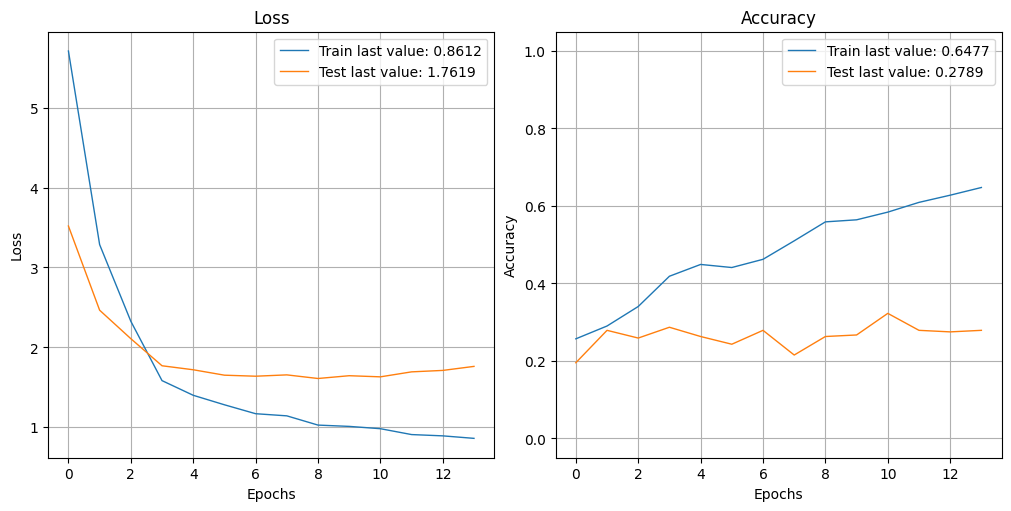

In [111]:
# plot blabla

show_history(history2)
plot_history(history2, path = 'standard.png')
plt.close()

## Approche nouvelle par Dataset sans data augmentation

tutoriel : https://www.tensorflow.org/tutorials/load_data/images

In [112]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory?utm_medium=email&utm_content=nov-18-has-completed-mentoring-session-student&bsft_clkid=7e7fcb5c-d2a5-4e5f-914e-7884d0b2fc1d&bsft_uid=3eac5941-ee98-433b-9ab8-a486990fcfdc&bsft_mid=57c0f452-3d55-4726-a8b5-e4e5d5294b7c&bsft_eid=7244055d-47f0-a6f2-c394-7a20ebb3a726&bsft_txnid=e812e4b6-3e28-4958-87b7-5751d7b01471&bsft_mime_type=html&bsft_ek=2024-03-01T15%3A37%3A01Z&bsft_aaid=a265d396-7432-4eb2-9c9a-ba5eea75629e&bsft_tv=14

In [113]:
# problème : dans exemple, chaque catégorie/label d'image est dans un sous-dossier différent
# comment ajouter l'information liée aux labels d'une autre façon ?

# labels = inferred -> labels are generated from the directory structure - pas possible aussi, nécessiterait de classer manuellement chaque image dans le bon dossier
# labels = None -> no labels
# dernière option -> list/tuple of integer labels of the same size as the number of image files found in the directory
# attention, avec la dernière option : Labels should be sorted according to the alphanumeric order of the image file paths (obtained via os.walk(directory) in Python)

In [114]:
# S'assurer de l'ordre de lecture des images par l'ordinateur
for (root, dirs, files_train) in os.walk('/Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/Images_train/train/'):
    print(root)
    print(dirs)
    print(files_train) # liste des images dans l'ordre de lecture

/Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/Images_train/train/
[]
['037c2402fee39fbc80433935711d1383.jpg', '42643c1c9403f67921a18654bcf45ead.jpg', '53f4bc7d7321f5c41de6b86e41f13e80.jpg', '9a9402ad55d079c86c302521816b7b0e.jpg', '42a8fef62716772c391fbdd148cc9c16.jpg', '503bb08f7bdf6a395ec564dd1dc83619.jpg', '42770faa04bfcf2b62e7ef335e1b1965.jpg', '9c4ab8ab059c912090c83cb0818e7f1c.jpg', '1d829e0eac91d7e85cdd6d581c363360.jpg', '5c7b493625b5fc6689cae49d25e1ae17.jpg', '06749cbff1487f470438823f6952cfd1.jpg', '473b1ab1abe21826c41efa1584a88a63.jpg', '07912328f580cf080d721e6466287896.jpg', '5cd3d274d71e1e0d6bf075421461b2d5.jpg', '7264f56639c8c54158b94ced769082c8.jpg', '0991e8d8f884003ab18890971191085d.jpg', '32da1bbf4f523bc8a8735701ce4b7726.jpg', '90453db0386931707b256dfa1e32c404.jpg', '40829ac110f344ef35f1c8c32fb311c7.jpg', '4b0e6f200426b1db8824b2ca0c59ecfa.jpg', '3fd4d7ea04624ada39fde3957c7b9b7c.jpg', '5479bb7028827d60000720a2c135976a.jpg', '6136976dc5a433cdf8e2559

In [115]:
files_train

['037c2402fee39fbc80433935711d1383.jpg',
 '42643c1c9403f67921a18654bcf45ead.jpg',
 '53f4bc7d7321f5c41de6b86e41f13e80.jpg',
 '9a9402ad55d079c86c302521816b7b0e.jpg',
 '42a8fef62716772c391fbdd148cc9c16.jpg',
 '503bb08f7bdf6a395ec564dd1dc83619.jpg',
 '42770faa04bfcf2b62e7ef335e1b1965.jpg',
 '9c4ab8ab059c912090c83cb0818e7f1c.jpg',
 '1d829e0eac91d7e85cdd6d581c363360.jpg',
 '5c7b493625b5fc6689cae49d25e1ae17.jpg',
 '06749cbff1487f470438823f6952cfd1.jpg',
 '473b1ab1abe21826c41efa1584a88a63.jpg',
 '07912328f580cf080d721e6466287896.jpg',
 '5cd3d274d71e1e0d6bf075421461b2d5.jpg',
 '7264f56639c8c54158b94ced769082c8.jpg',
 '0991e8d8f884003ab18890971191085d.jpg',
 '32da1bbf4f523bc8a8735701ce4b7726.jpg',
 '90453db0386931707b256dfa1e32c404.jpg',
 '40829ac110f344ef35f1c8c32fb311c7.jpg',
 '4b0e6f200426b1db8824b2ca0c59ecfa.jpg',
 '3fd4d7ea04624ada39fde3957c7b9b7c.jpg',
 '5479bb7028827d60000720a2c135976a.jpg',
 '6136976dc5a433cdf8e2559b8510bdce.jpg',
 '968a2b3be84193e3f755c2fe71033a2c.jpg',
 '3f9c4d0e8c3bca

In [116]:
# utiliser df_image pour faire correspondre labels aux images dans le bon ordre
# reduire pour ne garder que les images du dossier train
df_image_train = df_image.loc[df_image['image_name'].isin(files_train)]
df_image_train.shape

(700, 4)

In [117]:
# sort df_image en utilisant liste d'images
df_image_train['image_name'] = df_image_train['image_name'].astype('category')
df_image_train['image_name'] = df_image_train['image_name'].cat.set_categories(files_train)
df_image_train.sort_values(['image_name'])

# faire la liste des labels
labels_train = df_image_train['label'].tolist()

In [118]:
# même chose pour dossier test
for (root, dirs, files_test) in os.walk('/Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/Images_test/test'):
    print(root)
    print(dirs)
    print(files_test) # liste des images dans l'ordre de lecture

# reduire pour ne garder que les images du dossier test
df_image_test = df_image.loc[df_image['image_name'].isin(files_test)]

# sort df_image en utilisant liste d'images
df_image_test['image_name'] = df_image_test['image_name'].astype('category')
df_image_test['image_name'] = df_image_test['image_name'].cat.set_categories(files_test)
df_image_test.sort_values(['image_name'])

# faire la liste des labels
labels_test = df_image_test['label'].tolist()

/Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/Images_test/test
[]
['aa68675f50a0551b8dadb954017a50a1.jpg', 'b144a363c107c7bdd91f32d6e28ba6f2.jpg', 'db3e2eeb4fe90d4755f2911d661eae95.jpg', 'f2fa99bfaa4aa65a2bd53337e140f949.jpg', 'a618354ba17cff64826558d81afc77ab.jpg', 'c063d07d78a55a21bf6c0e7c8ae46a6d.jpg', 'e99d9abb115a9bd580bcccf9ff4d4881.jpg', 'ab3f4b2d2ec007b7e0eaec213bfdbffc.jpg', 'e47b9f88b773b3fd97ab3b51642ff6fb.jpg', 'aadbc3b9c32c4535b1bfee7321c4c0e7.jpg', 'e80e5151787eb21b0cca0d7dc3b0c338.jpg', 'cab75cad4b3a3c593c753a1759df28e2.jpg', 'b6c339777814451815fe7950fd4c8536.jpg', 'e2cec0756030a25f294ead3acc0570d2.jpg', 'ed9817e8960a6a0d509061c54cfe5ac1.jpg', 'd21409978f5e404b53f89e444f7893fe.jpg', 'edb97bd2433fd9de301c8a44344777bb.jpg', 'cc2acb156df3202f172b280132ab459a.jpg', 'e1b2b3ad430dd738d958292441b6d046.jpg', 'b7ef3e6ec248f17f3a6a4697120ddb96.jpg', 'fb733e04ff2d72c59d8513eb574e81a2.jpg', 'fd369a1bb58ae02cd925dda7e9e1d00a.jpg', 'f4d4c2eec77732f56e47722d7a

In [119]:
batch_size = 32

In [120]:
def dataset_fct(batch_size, path, labels = None, validation_split = 0, data_type = None):
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels = labels, label_mode = 'int',
                    class_names = None, batch_size = batch_size, image_size = (224, 224), shuffle = True, seed = 42,
                    validation_split = validation_split, subset = data_type
                    )
    return dataset

In [121]:
# ici nécessite d'avoir images train et test dans 2 dossiers différents
# -> séparer les images dans deux dossiers (train et test)

In [122]:
path = '/Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/Images_train/'
path_test = '/Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/Images_test/'

In [123]:
dataset_train = dataset_fct(batch_size, path, labels = labels_train, validation_split = 0.25, data_type = 'training')
dataset_val = dataset_fct(batch_size, path, labels = labels_train, validation_split = 0.25, data_type = 'validation')
dataset_test = dataset_fct(batch_size, path_test, labels = labels_test, validation_split = 0, data_type = None)

Found 700 files belonging to 1 classes.
Using 525 files for training.
Found 700 files belonging to 1 classes.
Using 175 files for validation.
Found 350 files belonging to 1 classes.


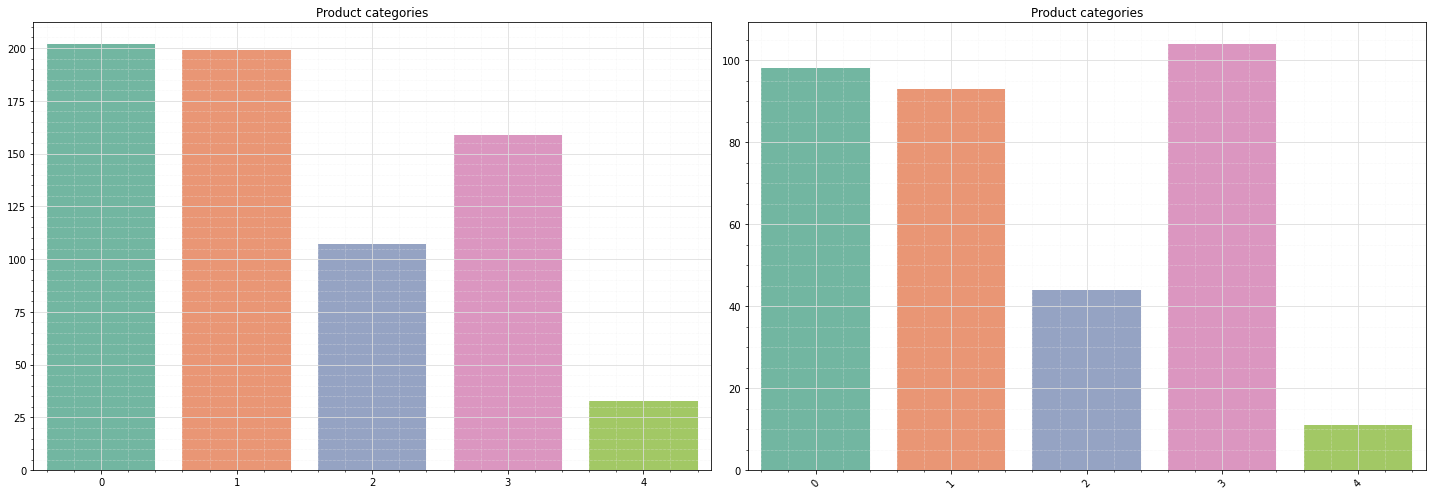

In [124]:
# Vérifier que les catégories sont bien représentées dans le train et le test

plt.figure(1, figsize = (20, 7))
# Barplot

product_categories_train = df_image_train['label'].value_counts()
product_categories_test = df_image_test['label'].value_counts()

plt.subplot(121)
sns.barplot(x = product_categories_train.index, y = product_categories_train.values)
plt.title('Product categories - train')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()

plt.subplot(122)
sns.barplot(x = product_categories_test.index, y = product_categories_test.values)
plt.title('Product categories - test')
plt.xticks(rotation = 45)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()

plt.tight_layout()
plt.show()

In [ ]:
# données manquantes sont toujours là ! 
# TO DO : virer les images non catégorisées des dossiers train et test

In [ ]:
dataset_train = fonctions.dataset_fct(batch_size, path, labels = labels_train, validation_split = 0.25, data_type = 'training')
dataset_val = fonctions.dataset_fct(batch_size, path, labels = labels_train, validation_split = 0.25, data_type = 'validation')

Found 700 files belonging to 1 classes.
Using 525 files for training.
Found 700 files belonging to 1 classes.
Using 175 files for validation.


In [125]:
dataset_test = fonctions.dataset_fct(batch_size, path_test, labels = labels_test, validation_split = 0, data_type = None)

Found 350 files belonging to 1 classes.


In [126]:
# Création du modèle
with tf.device('/gpu:0'):
    model3 = fonctions.create_model_fct_2()

# Création du callback
model3_save_path = './model3_best_weights.h5'
checkpoint = ModelCheckpoint(model3_save_path, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
callbacks_list = [checkpoint, es]

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [127]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [128]:
dataset_train

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [129]:
with tf.device('/gpu:0'):
    history3 = model3.fit(
        dataset_train,
        validation_data = dataset_val,
        batch_size = batch_size,
        epochs = 50,
        callbacks = callbacks_list,
        verbose = 1
        )

Epoch 1/50


2024-03-09 13:16:27.634335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 9.1714 - accuracy: 0.2800

2024-03-09 13:16:38.630477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 5.04809, saving model to ./model3_best_weights.h5
17/17 [==============================] - 16s 841ms/step - loss: 9.1714 - accuracy: 0.2800 - val_loss: 5.0481 - val_accuracy: 0.2400
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 5.4183 - accuracy: 0.3524
Epoch 2: val_loss improved from 5.04809 to 3.89203, saving model to ./model3_best_weights.h5
17/17 [==============================] - 15s 789ms/step - loss: 5.4183 - accuracy: 0.3524 - val_loss: 3.8920 - val_accuracy: 0.2571
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 3.7913 - accuracy: 0.3924
Epoch 3: val_loss improved from 3.89203 to 3.08425, saving model to ./model3_best_weights.h5
17/17 [==============================] - 15s 806ms/step - loss: 3.7913 - accuracy: 0.3924 - val_loss: 3.0842 - val_accuracy: 0.2343
Epoch 4/50
17/17 [==============================] - ETA: 0s - loss: 2.7523 - accuracy: 0.4343
Epoch 4: val_loss improved from 3.08425 to 2.9

In [130]:
# attention avec la loss
# si labels sont one-hot-encodés -> categorical_crossentropy
# si labels sont des ints -> sparse_categorical_crossentropy

# avantage de categorical_crossentropy -> peut donner class probabilities

# si labels sont binaires -> binary_categorical_crossentropy (aussi besoin de modifier la fonction d'activation en Sigmoid)

In [131]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose = True)
print('Training Accuracy : {:.4f}'.format(accuracy))

loss, accuracy = model3.evaluate(dataset_val, verbose = True)
print('Validation Accuracy : {:.4f}'.format(accuracy))

17/17 [==============================] - 11s 571ms/step - loss: 0.2328 - accuracy: 0.8781
Training Accuracy : 0.8781
6/6 [==============================] - 4s 535ms/step - loss: 2.7433 - accuracy: 0.2057
Validation Accuracy : 0.2057


In [132]:
# Score de l'epoch optimal
model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose = False)
print('Validation Accuracy : {:.4f}'.format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose = False)
print('Test Accuracy : {:.4f}'.format(accuracy))


Validation Accuracy : 0.1943
Test Accuracy : 0.2086


In [133]:
# est-ce que les catégories sont bien balancées dans mon train et mon test ?
# accuracy du test -> 0.25 - equivalent à ce qu'on aurait si on prenait une catégorie au hasard (1 chance sur 4)

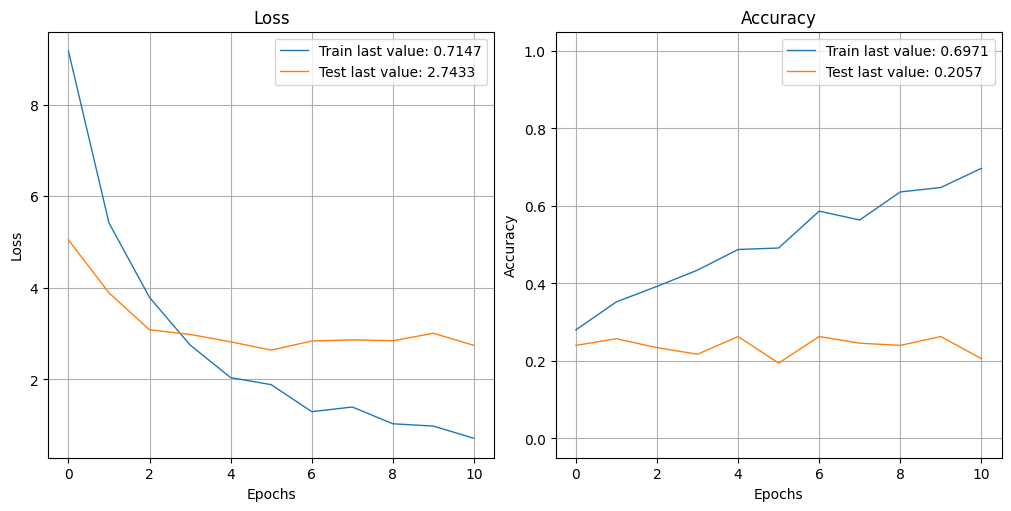

In [134]:
# plot blablabla

show_history(history3)
plot_history(history3, path = 'standard.png')
plt.close()

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [135]:
# data augmentation -> fait appel à la carte graphique
# vérifier les bons installs

In [136]:
batch_size = 32

In [137]:
#dataset_train = fonctions.dataset_fct(batch_size, path, validation_split = 0.25, data_type = 'training')
#dataset_val = fonctions.dataset_fct(batch_size, path, validation_split = 0.25, data_type = 'validation')
#dataset_test = fonctions.dataset_fct(batch_size, path_test, validation_split = 0, data_type = None)

In [138]:
dataset_train = dataset_fct(batch_size, path, labels = labels_train, validation_split = 0.25, data_type = 'training')
dataset_val = dataset_fct(batch_size, path, labels = labels_train, validation_split = 0.25, data_type = 'validation')
dataset_test = dataset_fct(batch_size, path_test, labels = labels_test, validation_split = 0, data_type = None)

Found 700 files belonging to 1 classes.
Using 525 files for training.
Found 700 files belonging to 1 classes.
Using 175 files for validation.
Found 350 files belonging to 1 classes.


In [139]:
def create_model_fct2():
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip('horizontal', input_shape = (224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])

    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset = -1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation = 'relu'),
                Dropout(0.5),
                Dense(4, activation = 'softmax')
                ])

    # compilation du modèle 
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    print(model.summary())

    return model

In [140]:
# Création du modèle
with tf.device("/gpu:0"):
    #model4 = fonctions.create_model_fct2()
    model4 = create_model_fct2()

# Création du callback
model4_save_path = './model4_best_weights.h5'
checkpoint = ModelCheckpoint(model4_save_path, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
callbacks_list = [checkpoint, es]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [141]:
tf.config.set_soft_device_placement(True) 

In [142]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [143]:
with tf.device('/gpu:0'):
    history4 = model4.fit(
        dataset_train,
        validation_data = dataset_val,
        batch_size = batch_size,
        epochs = 50,
        callbacks = callbacks_list,
        verbose = 1
        )

Epoch 1/50


2024-03-09 13:19:42.928492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.4552 - accuracy: 0.2343

2024-03-09 13:19:57.930801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.30361, saving model to ./model4_best_weights.h5
17/17 [==============================] - 20s 978ms/step - loss: 1.4552 - accuracy: 0.2343 - val_loss: 1.3036 - val_accuracy: 0.3086
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 1.3110 - accuracy: 0.2971
Epoch 2: val_loss did not improve from 1.30361
17/17 [==============================] - 16s 887ms/step - loss: 1.3110 - accuracy: 0.2971 - val_loss: 1.3075 - val_accuracy: 0.2743
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 1.2937 - accuracy: 0.3029
Epoch 3: val_loss did not improve from 1.30361
17/17 [==============================] - 17s 912ms/step - loss: 1.2937 - accuracy: 0.3029 - val_loss: 1.3188 - val_accuracy: 0.2629
Epoch 4/50
17/17 [==============================] - ETA: 0s - loss: 1.2719 - accuracy: 0.3295
Epoch 4: val_loss did not improve from 1.30361
17/17 [==============================] - 18s 981ms/step - loss: 1.2719 - accuracy: 0.3295 -

In [144]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose = True)
print('Training Accuracy : {:.4f}'.format(accuracy))

loss, accuracy = model4.evaluate(dataset_val, verbose = True)
print('Validation Accuracy : {:.4f}'.format(accuracy))

17/17 [==============================] - 11s 551ms/step - loss: 1.2332 - accuracy: 0.3619
Training Accuracy : 0.3619
6/6 [==============================] - 4s 518ms/step - loss: 1.3875 - accuracy: 0.2286
Validation Accuracy : 0.2286


In [145]:
# Score de l'epoch optimal
model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose = False)
print('Validation Accuracy : {:.4f}'.format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose = False)
print('Test Accuracy : {:.4f}'.format(accuracy))


Validation Accuracy : 0.3086
Test Accuracy : 0.2657


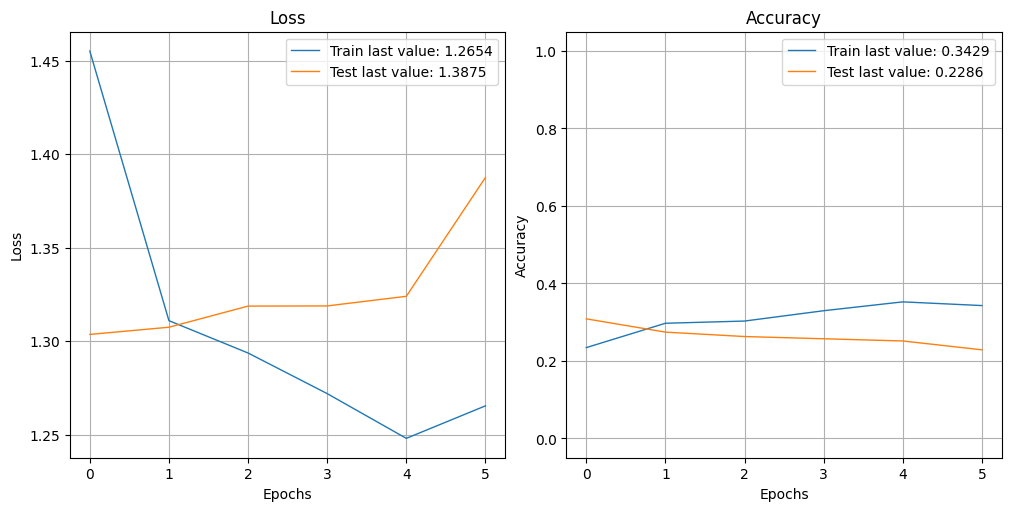

In [146]:
# plot blablabla

show_history(history4)
plot_history(history4, path = 'standard.png')
plt.close()

In [147]:
# si données désequilibrées -> data augmentation ne va pas aider les perfs
# bien comprendre comment fonctionne la data augmentation pour être sûre que ça ne déséquilibre pas les données

In [148]:
# si performances ne sont pas améliorées avec des catégories bien équilibrées dans le train et le test -> argumenter en mettant en avant la faible qualité/fiabilité des labels (mais ne pas les refaire moi même)
# proposer pourquoi pas une approche non supervisée etc...